# 💻 01 - Image filtering

Images contain a tremendous amount of data. A $640 \times 480$ grayscale image contains 307,200 pixels, each of which can take on one of 256 different values. Reasoning over raw images as a means of making estimating the structure of a robot's environment is intractable, particularly when we want to process images in real-time as they are streamed at 30 frames-per-second from a robot's camera.

<figure>
  <div style="text-align:center;">
  <img src="../images/image_filtering/image-filtering-block-diagram.pdf", width=400px>
  <figcaption>Image filtering performs local operations on an image using a kernel matrix as a means of enhancing its content.</figcaption>
  </div>
</figure>

Image filtering provides a means of enhancing an image by amplifying certain desireable aspects of the image while supressing others. The result is a transformation of the original raw image into a more concise collection of salient information.

<figure>
  <div style="text-align:center;">
  <img src="../images/image_filtering/image-filtering-local-window.pdf", width=400px>
  <figcaption>Image filtering performs local operations on an image using a kernel matrix as a means of enhancing its content.</figcaption>
  </div>
</figure>

In image filtering, each pixel in the output image is computed from a weighted combination of the neighboring pixels in the input image. This weighting is is referred to as the *filter kernel* and takes the form of a small (relative to the image) matrix $h$. Importantly, the kernel is the same everywhere in the image. 

Mathematically, we can represent image filtering as the process of convolving the image with the kernel filter

$$Y = I*h$$

which, for each pixel $u,v$ in the output image becomes

$$Y[u,v] = \sum_{k,l} h[k,l]I[u-k,v-l]$$

Notice that the $I[u-k,v-l]$ inside the sum has the effect of flipping the kernel $h$ left-to-right and top-to-bottom.

The kernel determines which content is amplified and which is supressed, and so we design the kernel based upon how we want to enhance the image.

**Example: Image blurring**

In this example, we are given a noisy image and want to design a filter that removes as much of the noise as possible, while losing too much of the actual detail. A candidate for such a filter is the *box filter*, a normalized matrix of ones.

$$ h = \frac{1}{N} 
\begin{bmatrix}
1 & 1 & \cdots & 1\\
1 & 1 & \cdots & 1\\
\vdots & \vdots & \ddots & \vdots\\
1 & 1 & \cdots & 1
\end{bmatrix}
$$

where $N$ is the number of elements in the matrix. In designing a box filter, we have freedom to decide on the width and height of the kernel, though we will assume that the matrix is square. Increasing the size of the kernel means that a greater number of neighboring pixels will be used in determining the average intensity at each output location. Intuitively, this will improve noise reduction at the expense of attenuating actual detail in the image.

In [213]:
### Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [239]:
img = cv2.imread('./images/image_filtering/zebra-noisy.jpg', 0)

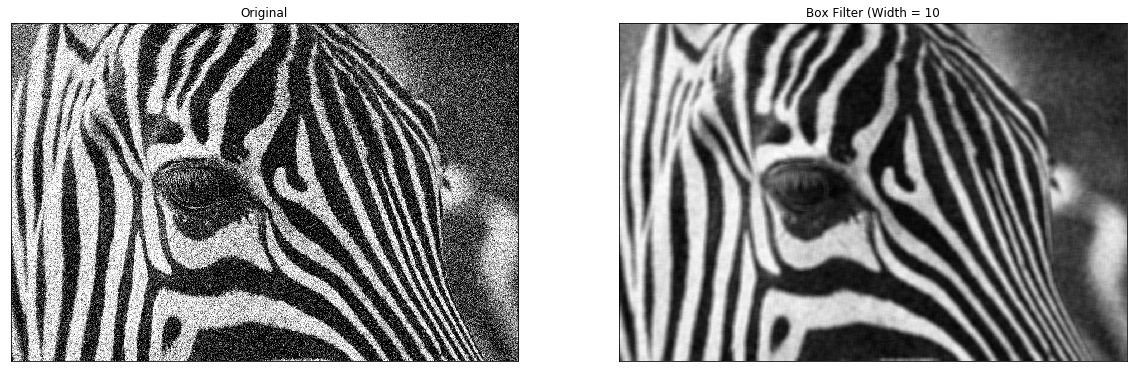

In [280]:
# TODO: The code below creates a 3x3 box filter. Compare the result of convolving the noisy image above with larger box filters.
#       Can you find the filter width above which too much detail is lost?
width = 10
hbox = np.ones((width,width), dtype=np.float32)
hbox = hbox/sum(hbox)

#filter the source image
img_box_filter = cv2.filter2D(img,-1,hbox)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img_box_filter,cmap = 'gray')
ax2.set_title('Box Filter (Width = ' + str(width)), ax2.set_xticks([]), ax2.set_yticks([]);

As we discussed in lecture, edges are a feature of an image that are used for a variety of tasks, including segmentation, object detection, shape estimation, and scene reconstruction. In the case of Duckietown and other self-driving domains, access to edge information is also very useful for detecting lane boundaries.

<figure>
  <div style="text-align:center;">
  <img src="../images/image_filtering/1d-intensity-change.pdf", width=800px>
  <figcaption>The change in intensity associated with an edge where an image transitions from white to black and black to white.</figcaption>
  </div>
</figure>

Edges correspond to significant changes in local intensity. This suggests that we can identify edges by looking for regions in the image where the intensity gradient $\nabla I$ is large. Consider the left-most image above, which might be a zoomed in view of one of the zebra's vertical stripes. Moving left-to-right along a single row of the image, we see that the intensity rapidly drops as the pixels transition from being white (i.e., close to 255) to black (i.e., closs to 0), and then stay small until they jump back up as the pixels go from black to white. The edges are clearly visible as spikes in the $x$-component of the intensity gradient.

In general, we are interested in the two-dimensional image gradient, which includes both horizontal as well as vertical changes in intensity:

$$ \nabla I = 
\begin{bmatrix}
\frac{\partial I}{\partial x}\\
\frac{\partial I}{\partial y}
\end{bmatrix}
$$

The magnitude of the gradient $\lvert \nabla I \rvert$ provides a measure of the strength of the edge.

Since pixels are discrete, we can't compute the derivatives analytically. Instead, we estimate them numerically via a finite difference approximation. We can compute these estimates by convolving the image with appropriately chosen kernels that compute finite derivatives in the $x$ and $y$ directions:

$$ \nabla I = 
\begin{bmatrix}
G_x\\
G_y
\end{bmatrix}
$$

where

$$ 
\begin{align}
G_x = h_x * I\\
G_y = h_y * I
\end{align}
$$

**Example: Image gradients**

In this example, you will design different filter kernels, $h_x$ and $h_y$, to estimate the horizontal and vertical gradients of an image. In doing so, remember that the filter will be flipped left-to-right and top-to-bottom when performing convolution.

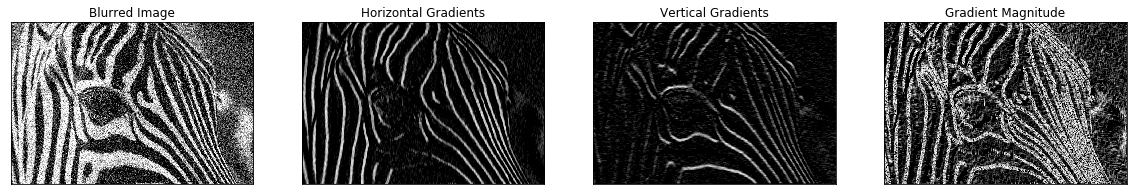

In [281]:
# TODO: Change the entries in the following filter kernels to estimate the horizontal and vertical gradients of an image
#       Feel free to also experiment with different filter sizes.
#       These filters will be applied to the blurred image that you generated above. As you experiment with different
#       kernels, compare the output for different amounts of blurring (i.e., different window) sizes. In particular, 
#       compare the gradients and their magnitude with little (i.e., width=3) or no blurring to an image blurred with a large kernel

hx = np.array([[1, 0, -1]], dtype=np.float32)
hy = np.array([[1, 0, -1]], dtype=np.float32).transpose()

# Apply the filters to the blurred image
Gx = cv2.filter2D(img_box_filter,-1,hx)
Gy = cv2.filter2D(img_box_filter,-1,hy)


# Compute the magnitude of the gradients
Gmag = np.sqrt(Gx*Gx + Gy*Gy)

# Visualize the filtered image alongside the original image.
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Blurred Image'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(Gx,cmap = 'gray')
ax2.set_title('Horizontal Gradients'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(Gy,cmap = 'gray')
ax3.set_title('Vertical Gradients'), ax3.set_xticks([]), ax3.set_yticks([]);
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(np.uint8(Gmag),cmap = 'gray')
ax4.set_title('Gradient Magnitude'), ax4.set_xticks([]), ax4.set_yticks([]);

As we discussed in lecture, while the box filter is intuitive, using it to smooth an image prior to computing numerical derivatives can result in artefacts. In practice, people commonly use a kernel that approximates a Gaussian

$$ G_\sigma = \frac{1}{2 \pi \sigma^2} e^{-\frac{x^2+y^2}{2}} $$

where $\sigma$ is the standard deviation and we have assumed zero-mean. The advantage of using a Gaussian kernel over a box filter is that it places more weight on nearby neighbors than it does on those that are farther away.

While Gaussians have infinite support, we are interested in a finite (and typically small) kernel. Thus, we will truncate the Gaussian based on the size of the kernel and then normalize such that all the entries sum to one.

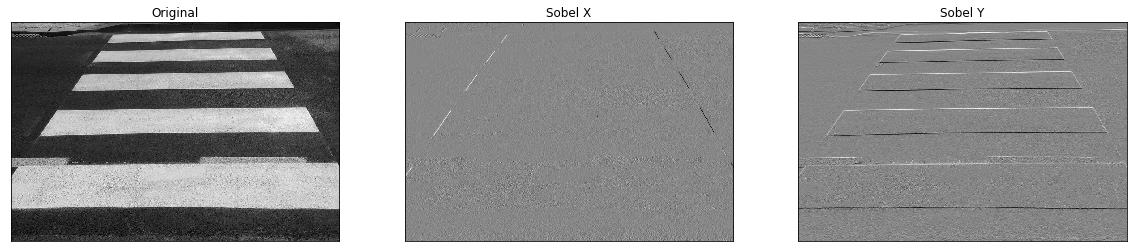

In [234]:
img = cv2.imread('./images/zebra-stripes.jpg', 0)
#img = cv2.GaussianBlur(imga,(0,0), 4)

# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1)

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);

In [12]:
class FindEdges:
    def __init__(
        self,
        canny_thresholds=[80, 200],
        canny_aperture_size=3,
        dilation_kernel_size=3,
        hough_threshold=2,
        hough_min_line_length=3,
        hough_max_line_gap=1):

        self.canny_thresholds = canny_thresholds
        self.canny_aperture_size = canny_aperture_size
        self.dilation_kernel_size = dilation_kernel_size
        self.hough_threshold = hough_threshold
        self.hough_min_line_length = hough_min_line_length
        self.hough_max_line_gap = hough_max_line_gap

        # initialize the variables that will hold the processed images
        self.bgr = np.empty(0)  #: Holds the ``BGR`` representation of an image
        self.hsv = np.empty(0)  #: Holds the ``HSV`` representation of an image
        self.canny_edges = np.empty(0)  #: Holds the Canny edges of an image
    def setImage(self, image):
        """
        Sets the :py:attr:`bgr` attribute to the provided image. Also stores
        an `HSV <https://en.wikipedia.org/wiki/HSL_and_HSV>`_ representation of the image and the
        extracted `Canny edges <https://en.wikipedia.org/wiki/Canny_edge_detector>`_. This is separated from
        :py:meth:`detectLines` so that the HSV representation and the edge extraction can be reused for multiple
        colors.
        Args:
            image (:obj:`numpy array`): input image
        """

        self.bgr = np.copy(image)
        self.hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        self.canny_edges = self.findEdges()
    def findEdges(self):
        """
        Applies `Canny edge detection <https://en.wikipedia.org/wiki/Canny_edge_detector>`_ to a ``BGR`` image.
        Returns:
            :obj:`numpy array`: a binary image with the edges
        """
        edges = cv2.Canny(
            self.bgr,
            self.canny_thresholds[0],
            self.canny_thresholds[1],
            apertureSize=self.canny_aperture_size,
        )
        return edges
    def colorFilter(self, color_range):
        """
        Obtains the regions of the image that fall in the provided color range and the subset of the detected Canny
        edges which are in these regions. Applies a `dilation <https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm>`_
        operation to smooth and grow the regions map.
        Args:
            color_range (:py:class:`ColorRange`): A :py:class:`ColorRange` object specifying the desired colors.
        Returns:
            :obj:`numpy array`: binary image with the regions of the image that fall in the color range
            :obj:`numpy array`: binary image with the edges in the image that fall in the color range
        """
        # threshold colors in HSV space
        map = color_range.inRange(self.hsv)

        # binary dilation: fills in gaps and makes the detected regions grow
        kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (self.dilation_kernel_size, self.dilation_kernel_size)
        )
        map = cv2.dilate(map, kernel)

        # extract only the edges which come from the region with the selected color
        edge_color = cv2.bitwise_and(map, self.canny_edges)

        return map, edge_color
    def getImage(self):
        """
        Provides the image currently stored in the :py:attr:`bgr` attribute.
        Returns:
            :obj:`numpy array`: the stored image
        """
        return self.bgr
    def detectLines(self, color_range):
        """
        Detects the line segments in the currently set image that occur in and the edges of the regions of the image
        that are within the provided colour ranges.
        Args:
            color_range (:py:class:`ColorRange`): A :py:class:`ColorRange` object specifying the desired colors.
        Returns:
            :py:class:`Detections`: A :py:class:`Detections` object with the map of regions containing the desired colors, and the detected lines, together with their center points and normals,
        """
        map, edge_color = self.colorFilter(color_range)
        lines = self.houghLine(edge_color)
        centers, normals = self.findNormal(map, lines)
        return Detections(lines=lines, normals=normals, map=map, centers=centers)


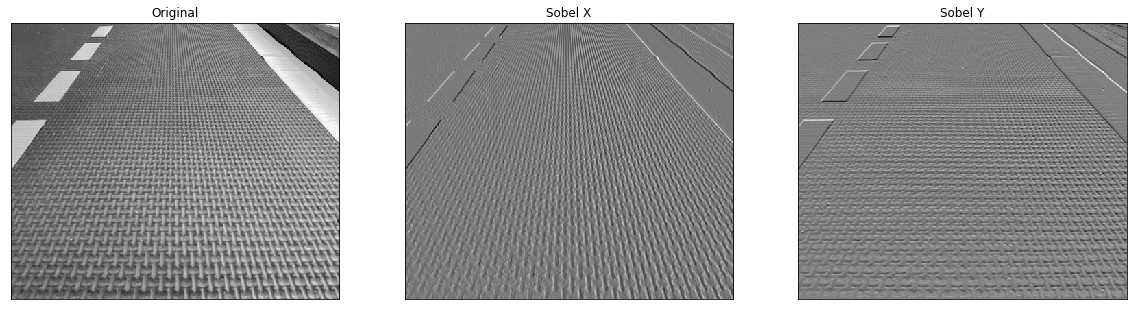

In [190]:
img = cv2.imread('./images/duckietown-lane-crop-small.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1)

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_gray,cmap = 'gray')
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);

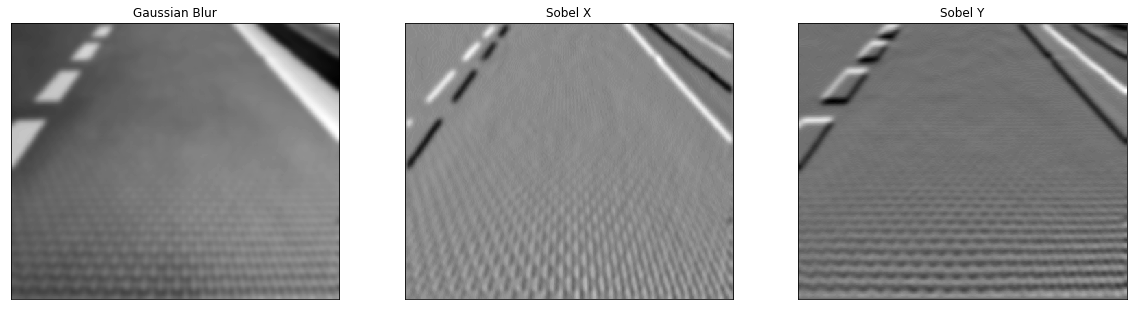

In [191]:
# Now smooth the image with a Gaussian kernel
img_gray_blurred = cv2.GaussianBlur(img_gray,(0,0), 4)

# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gray_blurred,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gray_blurred,cv2.CV_64F,0,1)

fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_gray_blurred,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(sobelx,cmap = 'gray')
ax2.set_title('Sobel X'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(sobely,cmap = 'gray')
ax3.set_title('Sobel Y'), ax3.set_xticks([]), ax3.set_yticks([]);

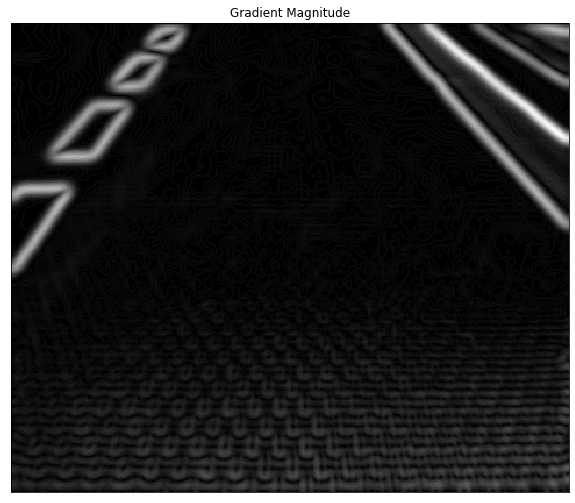

In [193]:
# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Compute the orientation of the gradients
Gdir = cv2.phase(np.array(sobelx, np.float32), np.array(sobely, dtype=np.float32), angleInDegrees=True)
#Gdir = np.arctan2(np.array(sobelx, np.float32), np.array(sobely, np.float32))

# Render the gradient magnitude
Gmag_8u = np.uint8(Gmag)
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(Gmag_8u, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([]);

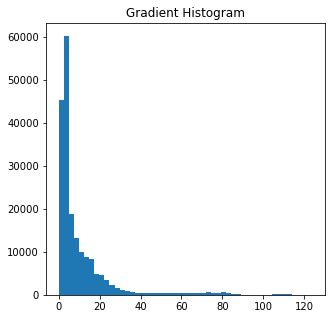

In [195]:
# Visualize the histogram over gradient magnitudes
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(Gmag.flatten(), bins=50)
ax1.set_title('Gradient Histogram');

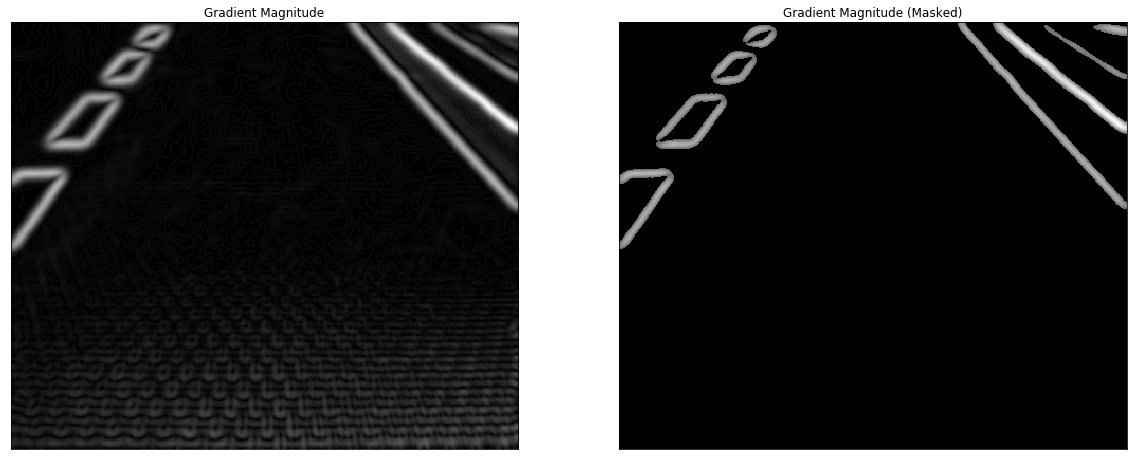

In [203]:
# We are only intersted in edges with stronger gradients and need to identify a threshold on the magnitude below which we ignore gradients. We can pick a threshold based on the histogram above and the resulting masked gradient magnitude image
threshold = 50
mask_mag = (Gmag > threshold)
#plt.imshow(mask_mag*Gmag)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Gmag_8u, cmap = 'gray')
ax1.set_title('Gradient Magnitude'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_mag*Gmag_8u,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([]);

In [204]:
# Let's consider the filter responses for the left- and right-halves of the image
width = img_gray.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,int(np.floor(width/2)):width + 1] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,0:int(np.floor(width/2))] = 0

In [143]:
# In the left-half image, we are interested in the right-half of the dashed yellow line, which corresponds to negative x- and y-derivatives
# In the right-half image, we are interested in the left-half of the solid white line, which correspons to a positive x-derivative and a negative y-derivative
# Generate a mask that identifies pixels based on the sign of their x-derivative
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)

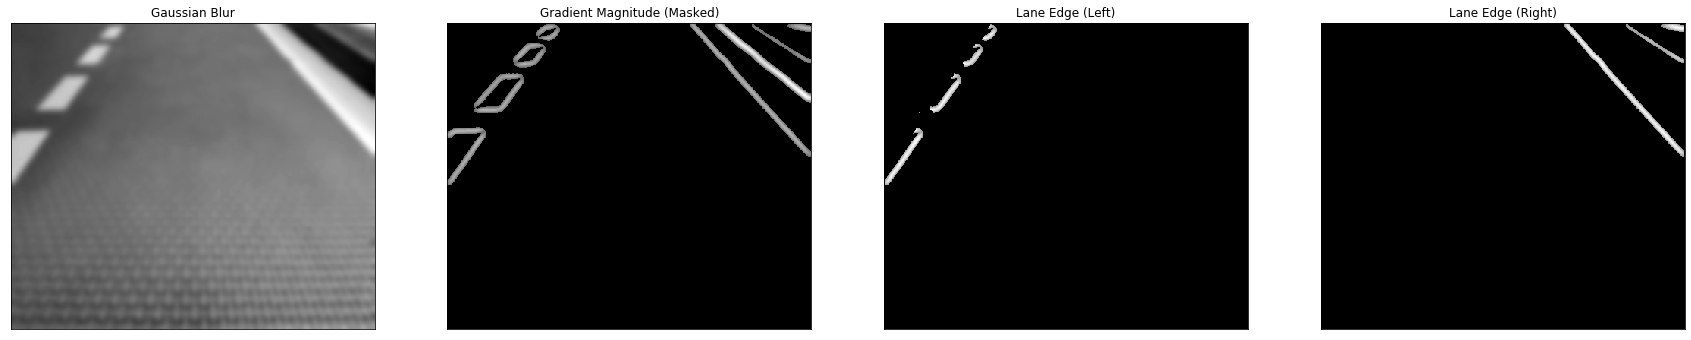

In [207]:
# Let's combine these masks with the gradient magnitude mask
mask_left_edge = mask_left * mask_mag * mask_sobelx_neg
mask_right_edge = mask_right * mask_mag * mask_sobelx_pos

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img_gray_blurred,cmap = 'gray')
ax1.set_title('Gaussian Blur'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(mask_mag*Gmag,cmap = 'gray')
ax2.set_title('Gradient Magnitude (Masked)'), ax2.set_xticks([]), ax2.set_yticks([])
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(Gmag * mask_left_edge, cmap = 'gray')
ax3.set_title('Lane Edge (Left)'), ax3.set_xticks([]), ax3.set_yticks([])
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(Gmag * mask_right_edge,cmap = 'gray')
ax4.set_title('Lane Edge (Right)'), ax4.set_xticks([]), ax4.set_yticks([]);

Text(0.5, 1.0, 'Gradient Direction Histogram (Left Edge)')

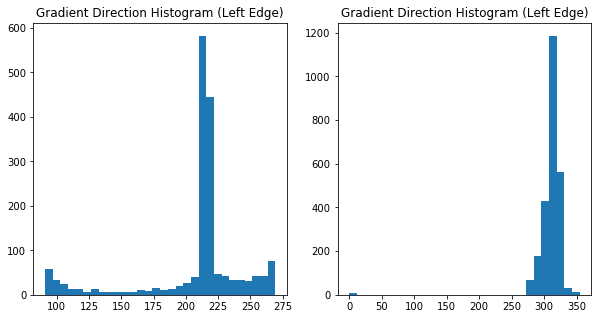

In [163]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(np.extract(mask_right_edge, Gdir).flatten(), bins=30)
ax2.set_title('Gradient Direction Histogram (Left Edge)')

In [208]:
# Determine the orientation of the left and right gradients as the mode of each histogram
(hist_left_edge, bins_left_edge) = np.histogram(np.extract(mask_left_edge, Gdir).flatten(), bins=30)
(hist_right_edge, bins_right_edge) = np.histogram(np.extract(mask_right_edge, Gdir).flatten(), bins=30)

idx = hist_left_edge.argmax()
theta_left = (bins_left_edge[idx] + bins_left_edge[idx+1])/2
idx = hist_right_edge.argmax()
theta_right = (bins_right_edge[idx] + bins_right_edge[idx+1])/2

In [209]:
theta_right

313.2401428222656

In [97]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = np.array([np.extract(mask, sobelx).flatten(), np.extract(mask, sobely).flatten()])
pca.fit(X.transpose())


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [88]:
pca.components_.shape

(2, 2)

In [98]:
#print(pca.singular_values_)
print(pca.components_[:,0:2])
temp = cv2.phase(np.array(pca.components_[0,:], np.float32), np.array(pca.components_[1,:], dtype=np.float32), angleInDegrees=True)

[[-0.54181743  0.84049621]
 [ 0.84049621  0.54181743]]


In [94]:
np.arctan2(-0.88186811, -0.47149616)*180/np.pi


-118.13145953754726